# Preparing Data for NeRF

1. Run COLMAP reconstruction on images
2. Export model (binary files in sparse folder) to text files
3. Downsample N images by a scale factor, shape=(N, width/sf, height/sf, 3)
4. Extract camera pose data from text files, shape=(N, 4, 4) 
5. Divide camera focal length by the scale factor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import cv2
import os
%matplotlib inline

In [2]:
downsampled_image_dir = "../COLMAP Projects/OIVIO Tunnel/downsamples/"
sparse_dir = "../COLMAP Projects/OIVIO Tunnel/workspace/sparse/0/"

SCALE_FACTOR = 10  # Same scale factor used for image downsampling

### Get data from text files

In [3]:
cameras_txt = os.path.join(sparse_dir, "cameras.txt")
images_txt = os.path.join(sparse_dir, "images.txt")

cameras_cols = ["Camera_ID", "Model", "Width", "Height", "Focal", "Param_1", "Param_2", "Param_3"]
images_cols = ["Image_ID", "qw", "qx", "qy", "qz", "tx", "ty", "tz", "Camera_ID", "Filename"]

# Make sure cameras data has only 1 camera (Simple_Radial)
cameras_data = pd.read_csv(cameras_txt, sep=" ", names=cameras_cols,
                           skiprows=range(3), index_col="Camera_ID")  # Skip first 3 rows

# Custom skip rows function
def image_skip_rows(index):
    # Skip first 4 rows as they are comments
    if index in range(4):
        return True
    # Skip odd indexed rows as it is unnecessary points data
    elif index % 2 == 1:
        return True
    else:
        return False

images_data = pd.read_csv(images_txt, sep=" ", names=images_cols,
                           skiprows=lambda x: image_skip_rows(x), index_col="Image_ID")  # Skip first 4 rows
images_data

,qw,qx,qy,qz,tx,ty,tz,Camera_ID,Filename
Image_ID,,,,,,,,,
1,0.992584,-0.019638,-0.119769,-0.006872,-0.254633,0.348870,6.484507,1,1552660936897507840.png
2,0.992559,-0.019895,-0.120019,-0.005090,-0.257584,0.349841,6.392964,1,1552660936930844672.png
3,0.992561,-0.021222,-0.119829,-0.003580,-0.254852,0.362190,6.299704,1,1552660936964182784.png
4,0.992564,-0.022566,-0.119571,-0.003330,-0.251830,0.372575,6.205704,1,1552660936997520896.png
5,0.992564,-0.023666,-0.119307,-0.004795,-0.247670,0.375940,6.111188,1,1552660937030857728.png
...,...,...,...,...,...,...,...,...,...
146,0.992945,-0.044483,0.109843,0.004010,-2.175974,-0.557951,-5.216345,1,1552660941731477760.png
147,0.992232,-0.046986,0.115033,0.005996,-2.263827,-0.600145,-5.260612,1,1552660941764814848.png
148,0.991446,-0.049097,0.120740,0.006876,-2.360355,-0.640736,-5.301744,1,1552660941798152704.png


### Get camera focal length

In [4]:
focal_length = cameras_data["Focal"][1]  # Get focal length from camera 1

# Divide focal length by scale factor
focal_length = focal_length / SCALE_FACTOR

### Get image pixel data

In [5]:
images = []
image_filenames = images_data["Filename"]
for name in image_filenames:
    image_path = os.path.join(downsampled_image_dir, name)  # Get path to downsampled image
    
    image = cv2.imread(image_path)  # Read image into array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    images.append(image)
    
# Divide by 255 to get in range [0, 1] and convert to float
images = (np.array(images) / 255).astype(np.float32)

### Get pose data 

In [6]:
quaternions = images_data[["qx", "qy", "qz", "qw"]].to_numpy()  # X,Y,Z,W is the format needed for from_quat() below

# For N quaternion vectors, get the Nx3x3 rotation matrices
# Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
rotations = Rotation.from_quat(quaternions).as_matrix()

# Get translation vectors
translations = images_data[["tx", "ty", "tz"]].to_numpy()

poses = []
# Create Nx4x4 pose matrix for N images
for i in range(len(images)):
    pose = np.column_stack((rotations[i], translations[i]))  # Combine rotation matrix and translation vector along columns
    pose = np.vstack((pose, [0.0, 0.0, 0.0, 1.0]))  # Make matrix into square (4x4) by adding this row vector
    
    # COLMAP stores data in world-to-camera coordinates. Convert to camera-to-world coordinates by inverting the pose matrix
    pose = np.linalg.inv(pose)
    
    # Matrix to flip the sign of the y and z rotation axes. No need to flip the x rotation axis
    # Reference: https://github.com/NVlabs/instant-ngp/blob/master/scripts/colmap2nerf.py
    flip_mat = np.array([
        [1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1]
    ])
    
    pose = pose @ flip_mat  # Apply flip matrix to pose matrix
    
    poses.append(pose)
    
poses = np.array(poses).astype(np.float32)  # Convert to float

### Show data for some sample image

In [7]:
print("Images shape:", images.shape)
print("Poses shape:", poses.shape)

Images shape: (150, 72, 128, 3)
Poses shape: (150, 4, 4)


Focal length: 95.17170601433821
Poses:
[[ 0.9735716  -0.03006977 -0.22639371 -1.0673867 ]
 [-0.01814222 -0.9983444   0.05458296 -0.07143936]
 [-0.22766021 -0.04903314 -0.97250533 -5.4621873 ]
 [ 0.          0.          0.          1.        ]]


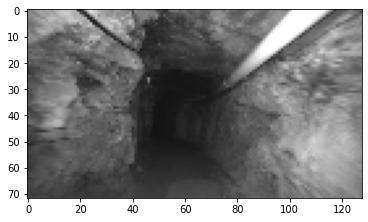

In [8]:
data_id = 10
print("Focal length:", focal_length)
print("Poses:")
print(poses[data_id])
plt.imshow(images[data_id])

### Check Pose Data is correct
Make sure the arrows (direction of the rays) point towards the center

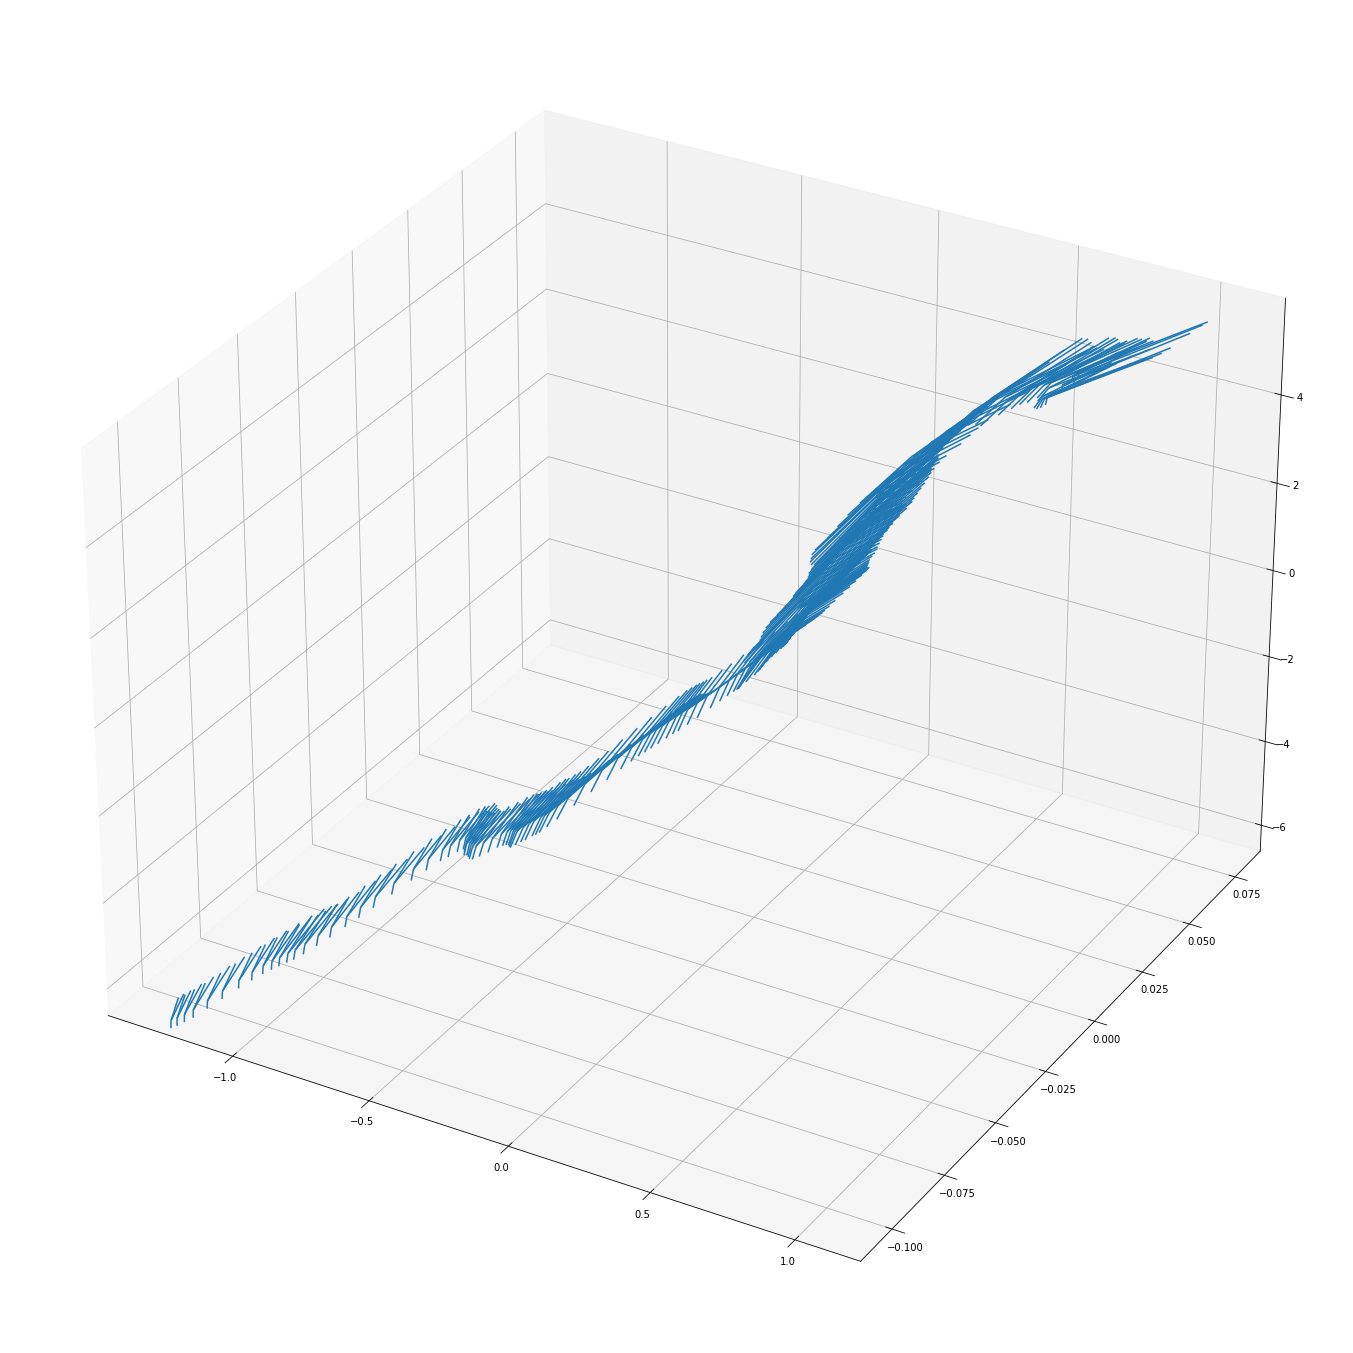

In [18]:
# Reference: https://colab.research.google.com/drive/1TppdSsLz8uKoNwqJqDGg8se8BHQcvg_K?usp=sharing
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(24, 64)).add_subplot(projection='3d')
_ = ax.quiver(
    origins[..., 0].flatten(),  # x-coord of origin
    origins[..., 1].flatten(),  # y-coord of origin
    origins[..., 2].flatten(),  # z-coord of origin
    dirs[..., 0].flatten(),  # x-coord of direction endpoint
    dirs[..., 1].flatten(),  # y-coord of direction endpoint
    dirs[..., 2].flatten(),  # z-coord of direction endpoint
    length=0.5, normalize=True)
plt.show()

### Save data as numpy object 

In [19]:
np.savez("oivio_tunnel.npz", images=images, poses=poses, focal=focal_length)